In [1]:
# Import 3rd party packages

using DifferentialEquations, StochasticDiffEq, LinearAlgebra, Calculus, Discretizers, KernelDensity, Distributions
using JLD2, FileIO, DataFrames, LaTeXStrings;
using DelimitedFiles,CSV, Query;
using Plots;

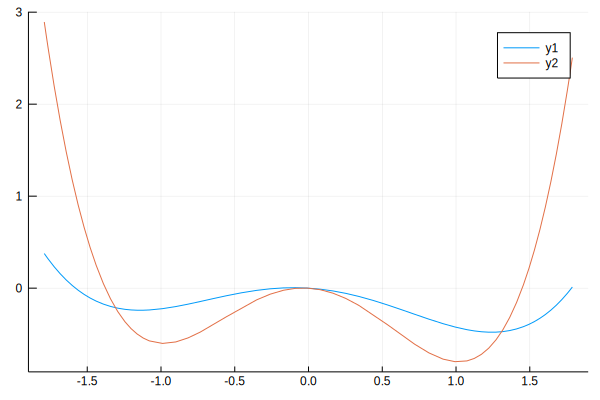

In [2]:
##################################
########### f_1 & f_2 ############
##################################
a1=0.7
b1=0.0
c1=1.0
d1=0.1
f_1(x) = (a1*x^4)/4 - (b1*x^3)/3 - (c1*x^2)/2 - d1*x

# stable stat: x=-1.14168; x=1.24240
# saddle: x=-0.100715

a3=2.8
b3=0.0
c3=2.8
d3=0.1
f_3(x) = (a3*x^4)/4 - (b3*x^3)/3 - (c3*x^2)/2 - d3*x

# stable stat: x=-0.98164; x=1.01740
# saddle: x=-0.035760

plot([f_1,f_3], -1.8, 1.8)

In [5]:
##################################
########## SDE FUNCTION ##########
##################################
function sde(x₀, α, a, c)
    b=0.0
    d=0.1
    f(x,p,t) = -a*x^3+b*x^2+c*x+d
    g(x,p,t) = α*x
    tspan = (0.0,10.0) 
    prob = SDEProblem(f,g,x₀,tspan)
    saveat = 0.001
    sol = solve(prob,alg_hints=[:stiff],saveat=saveat)
    return sol
end
##################################

sde (generic function with 1 method)

In [6]:
##################################
########### SIMULATION ###########
##################################

# Define some parameters

# Define noise term here
noise=[0.01,0.05,0.1]
# Create an array of initial conditions [start:step_size:stop]
# Is it worth having such a small step size??? - Investigate (0.1 vs. 0.01)
in_cond = collect(-2.0:0.1:2.0)
# Number of iterations per initial condition
# Is it worth having more iterations - investigate (100 vs. 1000)
iter = 100
# Values of c parameter to use when solving the SDE
params = [[a1,c1],[a3,c3]]

# Generate data according to 4 different functions (4 different values for c parameter)

# Array of solutions for each function
all_sols_f1_low = Array{RODESolution,2}(undef,iter,length(in_cond))
all_sols_f1_med = Array{RODESolution,2}(undef,iter,length(in_cond))
all_sols_f1_high = Array{RODESolution,2}(undef,iter,length(in_cond))

all_sols_f2_low = Array{RODESolution,2}(undef,iter,length(in_cond))
all_sols_f2_med = Array{RODESolution,2}(undef,iter,length(in_cond))
all_sols_f2_high = Array{RODESolution,2}(undef,iter,length(in_cond));

In [7]:
##################################
########### SIMULATION ###########
##################################

######################################################
# Loop over differing amounts of noise (low,med,high)
for n in noise
# Loop over each initial starting condition
    for temp_init in 1:length(in_cond)    
        # Run this code iter times for each starting condition
        for temp_iter in 1:iter
            for p in params
                sol_i = sde(in_cond[temp_init],n,p[1],p[2])
                if n == noise[1] && p == params[1]
                    all_sols_f1_low[temp_iter, temp_init] = sol_i
                elseif n == noise[2] && p == params[1]
                    all_sols_f1_med[temp_iter, temp_init] = sol_i
                elseif n == noise[3] && p == params[1]
                    all_sols_f1_high[temp_iter, temp_init] = sol_i
                elseif n == noise[1] && p == params[2]
                    all_sols_f2_low[temp_iter, temp_init] = sol_i
                elseif n == noise[2] && p == params[2]
                    all_sols_f2_med[temp_iter, temp_init] = sol_i
                elseif n == noise[3] && p == params[2]
                    all_sols_f2_high[temp_iter, temp_init] = sol_i
                end
            end               
        end
    end
end
######################################################

In [11]:
"""
Generate a normalized pdf from continuous data.
"""
function genkde(data)

    filter!(x -> !isnan(x), data)    # Remove nans from data

    kdeObj = kde(data)
    x = collect(range(minimum(data),stop=maximum(data),length=10000)) # length must be dt x 
    y_1 = map(z->pdf(kdeObj,z),x)
    y = log.(y_1)

    return (x,y)

end

genkde

In [9]:
########## OBTAIN VALUES FOR KDE AND PLOTTING PER FUNCTION PER NOISE LEVEL ##########

In [10]:
plot_step_size = 10;

# Generate continious data from all_sols for use in univariate kde per function
# data contains every 10th value for all timepoints 

data_f1_low = Array{Float64, 1}()
for ii in 1:length(in_cond)
    for jj in 1:iter
        data_f1_low = vcat(data_f1_low, all_sols_f1_low[jj,ii].u[1:plot_step_size:end])
    end
end
data_f1_med = Array{Float64, 1}()
for ii in 1:length(in_cond)
    for jj in 1:iter
        data_f1_med = vcat(data_f1_med, all_sols_f1_med[jj,ii].u[1:plot_step_size:end])
    end
end
data_f1_high = Array{Float64, 1}()
for ii in 1:length(in_cond)
    for jj in 1:iter
        data_f1_high = vcat(data_f1_high, all_sols_f1_high[jj,ii].u[1:plot_step_size:end])
    end
end

data_f2_low = Array{Float64, 1}()
for ii in 1:length(in_cond)
    for jj in 1:iter
        data_f2_low = vcat(data_f2_low, all_sols_f2_low[jj,ii].u[1:plot_step_size:end])
    end
end
data_f2_med = Array{Float64, 1}()
for ii in 1:length(in_cond)
    for jj in 1:iter
        data_f2_med = vcat(data_f2_med, all_sols_f2_med[jj,ii].u[1:plot_step_size:end])
    end
end
data_f2_high = Array{Float64, 1}()
for ii in 1:length(in_cond)
    for jj in 1:iter
        data_f2_high = vcat(data_f2_high, all_sols_f2_high[jj,ii].u[1:plot_step_size:end])
    end
end

In [ ]:
########## DENSITY ESTIMATION PER FUNCTION PER NOISE LEVEL ##########

In [12]:
x1_l,y1_l = genkde(data_f1_low)
x1_m,y1_m = genkde(data_f1_med)
x1_h,y1_h = genkde(data_f1_high)

x2_1,y2_l = genkde(data_f2_low)
x2_m,y2_m = genkde(data_f2_med)
x2_h,y2_h = genkde(data_f2_high);

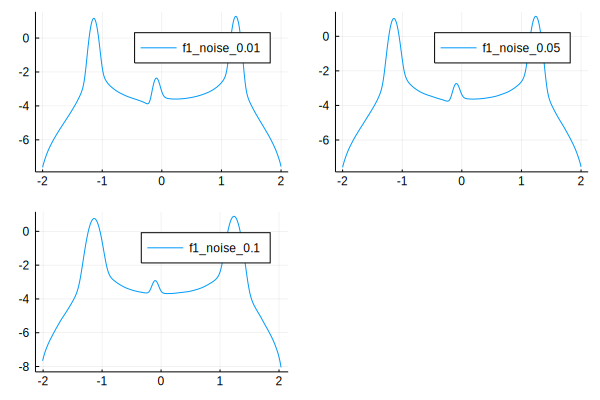

In [13]:
p1_l = plot(x1_l,y1_l)
p1_m = plot(x1_m,y1_m)
p1_h = plot(x1_h,y1_h)

fig = plot(p1_l,p1_m,p1_h,label=["f1_noise_0.01" "f1_noise_0.05" "f1_noise_0.1"])

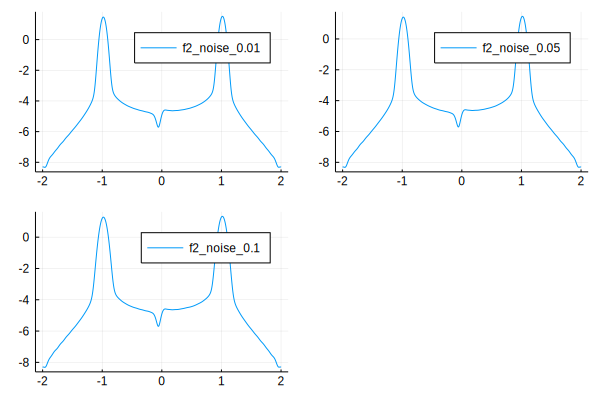

In [14]:
p2_l = plot(x2_1,y2_l)
p2_m = plot(x2_m,y2_m)
p2_h = plot(x2_h,y2_h)

fig = plot(p2_l,p2_m,p2_h,label=["f2_noise_0.01" "f2_noise_0.05" "f2_noise_0.1"])